## $\mu$ & $\theta$ changing with time

We'll start with a video to give us perspective on what is happening in the code below:

[Video: Lecture 11 Thick red arrows](https://youtu.be/Z2U5MpP3PO0)

We will now return to the example in [section 5.3](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/5%20Basic%20bioreactor%20modeling/The%20fermenter%20equation.ipynb). We'll intoduce substrate depeletion terms (Monod functions) and product inhibition for both the $\mu$ and $\theta$ rates. As before we will start with the flux model:

<img src="etmap.png" width="570" />



Unless stated otherwise, the parameters are the same as in section 5.3. We need to define maximum values for the physiological rates ($\mu$ & $\theta$):
 
 $\mu_{max}\,\left(\frac{1}{h} \right)$|$\theta_{max} \, \left(\frac{mol\, ATP}{cmol\, X\cdot h} \right) $
 -|-
 0.12 |0.1

The parameters of the various inhibition terms are given by:

|$K_M \, \left(\frac{cmol}{L} \right)$|$K_P \, \left(\frac{cmol}{L} \right)$|$C_P^* \,  \left(\frac{cmol}{L} \right)$
 -|-|-|-
 **Growth**|0.0004|$-$|1.95
 **Maintenance**|0.00005|2.5|$-$
 
 

Note that the following equations result from the table above:

$$\mu(C_S,C_P)= \mu_{max} \left[\frac{Cs}{K_m^{\mu}+Cs} \right]   \left[ 1-\frac{C_P}{{C_P^{*}}^{\mu}} \right] $$

$$\theta(C_S,C_P)= \theta_{max} \left[\frac{Cs}{K_m^{\theta}+Cs} \right]  \left[1+\frac{C_P}{K_P^{\theta}} \right]^{-1}  $$

$C_P$ refers to the ethanol concentration since glycerol has no inhibitory effect. 

We'll start by defining the parameters:

In [1]:
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline
alpha, beta, gamma = 0.1, 0.1,1.8
Km_mu, Km_theta = 0.0004, 0.00005
Cp_star, Kp = 1.95, 2.5
mumax, thetamax = 0.12, 0.1

The response function (or rate function) will now be altered to include the $\mu$ and $\theta$ functions. We'll only use the function for $\mu$ up to the point where a zero value is obtained:

In [2]:
def response_fun(C):
    
    Cx, Cs, Cg, Ce = C[0],C[1],C[2],C[3]   #Same component order as in the ferm-eq
    Cp = Ce                                #Ethanol is Cp 
    
    mu1=mumax*Cs/(Km_mu+Cs)*(1-Cp/Cp_star)
    theta=thetamax*Cs/(Km_theta+Cs)*(1+Cp/Kp)**(-1)
    
    if mu1 < 0.0001:   #Negative values of mu set to zero
        mu=0 
    else:
        mu=mu1
                 
    S = numpy.matrix([[-1,1+alpha,1,0,0],
                      [ 0,0,-1,1,1.5],
                      [  0,beta,0,-1/3,0],
                      [ 0,-gamma,-1/3,0,1],
                      [ 0,1,0,0,0]])

    K = numpy.matrix([0, 0, 0, theta, mu]).T
    r = numpy.linalg.solve(S, K) 
        
    
    return [r[1,0],   # important to see the order of the rates (X,S,G,E)
           -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
            r[3,0],   # glycerol
            r[4,0],   # ethanol   
            theta]

Note that the response function returns the rates for a given set of concentrations in the fermenter. The response function also returns $\theta$. Let's define an arbitrary condition in the fermenter where $C_S= 60 \frac{g}{L}$, $C_X= 12 \frac{g}{L}$, $C_G= 0 \frac{g}{L}$ and $C_E=C_P= 20 \frac{g}{L}$. We can calculate the rates for this specific fermenter condition:

In [3]:
rate1=response_fun([12/24.6,60/30,0,20/46])
rate1

[0.09322550205677925,
 -0.91745023142951776,
 0.027967650617033785,
 0.52462301903335118,
 0.085183055608795]

Can you see that the rate of ethanol production ($r_E$) is $0.525 \frac{\text{cmol Et}}{\text{cmol X}\cdot \text{h}}$? Can you see that both $\mu$ and $\theta$ is not at their maximum values anymore? 

We can even calculate the yield at these conditions. We'll use the term **instantaneous yield** since the yield will vary as the conditions in the fermenter vary. This yield will thus only apply at the specific point in time where the specific concentration conditions are obtained. Let's calculate the yield of ethanol on glucose ($Y_{SE}$): 

In [4]:
Yse1 = rate1[3]/-rate1[1]
Yse1

0.57182722404016839

We can now calculate the rates and yield at another concentration condition. Let's take $C_S= 20 \frac{g}{L}$,$C_X= 15 \frac{g}{L}$, $C_G= 0 \frac{g}{L}$ and $C_E=C_P= 100 \frac{g}{L}$. 

In [5]:
rate2=response_fun([20/24.6,15/30,0,100/46])
rate2

[-4.7755105284618349e-18,
 -0.16044907137193259,
 5.4509540098558525e-19,
 0.10696604758128839,
 0.0534830237906442]

Much lower rates and zero biomass formation. Can you understand why? **Try really hard**

Let's see if $Y_{SE}$ is different?

In [6]:
Yse2 = rate2[3]/-rate2[1]
Yse2

0.66666666666666663

Significantly higher yield! What was the contribution of maintenance and growth at this specific concentration condition? **Try really hard to explain it to yourself**

Before we integrate, we want to see how $\mu$ and $\theta$ change as $C_P$ increase. We'll ignore the possible influence of $C_S$ for now. Let's plot: 

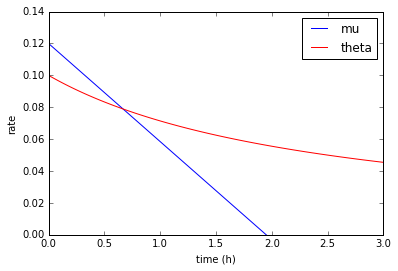

In [7]:
Cp_curve=numpy.linspace(0,3,100)
mu_curve=mumax*(1-Cp_curve/Cp_star)
theta_curve=thetamax*(1+Cp_curve/Kp)**(-1)

plt.plot(Cp_curve, mu_curve, color='blue', label='mu')
plt.plot(Cp_curve, theta_curve, color='red', label='theta')
plt.ylim([0,0.14])  #y limits on graph
plt.legend(loc='best')
plt.ylabel('rate') 
plt.xlabel('time (h)') 
plt.show()

You should see from the graph above that $\mu$ terminates at $C_P=1.95 \frac{cmol}{L}$, while $\theta$ only gradually decreases as $C_P$ increases. There will thus be a time at the end where only maintenance production of ethanol occurs, provided that sufficient substrate is left once growth has terminated. Let's integrate to see if we can observe this behaviour. The fermenter equation will be the same as before (batch fermenter):

In [8]:
def ferm_eq(C,t):
    Cx, Cs, Cg, Ce = C[0],C[1],C[2],C[3]  # order of components very important 
    r=response_fun([Cx, Cs, Cg, Ce])      # this is the 'fetching' from the response function
    
    return [r[0]*Cx,
            r[1]*Cx,    
            r[2]*Cx,
            r[3]*Cx]   

We'll use the following initial conditions. $C_X^0=0.001 \frac{cmol}{L}$ and $C_S^0=\frac{120}{30} \frac{cmol}{L}$

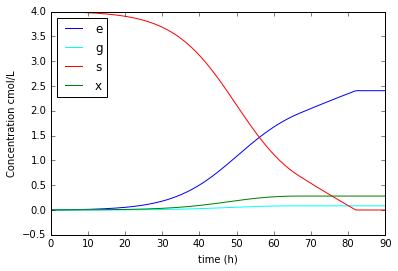

In [9]:
Co=[0.001, 120/30,0,0]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax=90                                    # Integrate for 20 hours  
tspan=numpy.linspace(0,tmax,200)           # define the timespan of the integration
C = odeint(ferm_eq, Co, tspan)             # integration via odeint that calls apon ferm_eq

Cx=C[:,0]                                  
Cs=C[:,1]
Cg=C[:,2]
Ce=C[:,3]

plt.plot(tspan, Ce, color='blue', label='e')
plt.plot(tspan, Cg, color='cyan', label='g')
plt.plot(tspan, Cs, color='red',label='s')
plt.plot(tspan, Cx, color='green',label='x')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

Interesting shapes! What is happening here? Let's have a closer look at the ethanol and biomass profiles: 

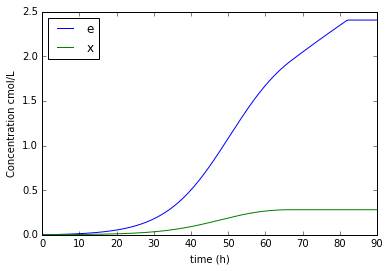

In [10]:
plt.plot(tspan, Ce, color='blue', label='e')
plt.plot(tspan, Cx, color='green',label='x')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

Can you make sense out of these shapes? Let's see what happens to the glycerol?

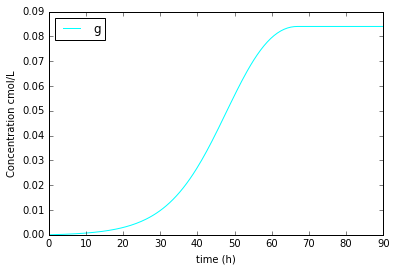

In [11]:
plt.plot(tspan, Cg, color='cyan', label='g')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

What is happening here? Play around with the answers. More to follow in the class example on this example.

### Class questions

a) Plot $r_E$ without using your computer. Share graphs among the group before testing with Jupyter notebooks.

Product yield and productivity are two crucial parameters for quantifying the economy of the fermenter. In short these paramenters can be defined as:

$$\text{Product yield}=\frac{\text{amount of targeted product made}}{\text{amount of feedstock spent}} \Rightarrow \frac{g}{g}$$

$$\text{Productivity}=\frac{\text{amount of product made}}{\text{volume of fermenter} \cdot \text{time}} \Rightarrow \frac{g}{L \cdot h}$$

We'll be using ethanol as targeted product and glucose as feedstock for the calculation. 



b) Determine $r_{E}^V$ and $Y_{E}$ at 40 minutes. Give in units $\frac{g}{L \cdot h}$ and $\frac{g}{g}$.

c) Determine $r_{E}^V$ and $Y_{E}$ at 70 minutes. Give in units $\frac{g}{L \cdot h}$ and $\frac{g}{g}$.

d) What is the overall product yield and productivity of the fermenter above?

e) Remove all product inhibition terms from $\mu$ and $\theta$ and determine product yield and productivity when all glucose is consumed. Before doing this draw the anticipated concentration graph within the group without using Jupyter. Also predict a productivity and yield increase/decrease relative to the base scenario before checking the figures on Jupyter.

f) Repeat (e) with zero maintenance product inhibition, while $C_E^*=0.5$ for the product inhibition of growth.